# 1 Пункт

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.linear_model import LinearRegression
from scipy.special import erfinv, erf
from sklearn.metrics import r2_score

In [2]:
random.seed(13)
np.random.seed(13)

In [3]:
data = pd.read_csv('/home/owid-covid-data.csv')
data.shape

(261268, 67)

In [4]:
data[data['location'] == 'Russia']

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
192649,RUS,Europe,Russia,2020-01-31,2.0,2.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,-5538.0,-3.33,-3.33,-38.03119
192650,RUS,Europe,Russia,2020-02-01,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
192651,RUS,Europe,Russia,2020-02-02,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
192652,RUS,Europe,Russia,2020-02-03,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
192653,RUS,Europe,Russia,2020-02-04,2.0,0.0,NaN,NaN,NaN,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193771,RUS,Europe,Russia,2023-02-26,21941582.0,9520.0,12265.000,388063.0,30.0,33.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
193772,RUS,Europe,Russia,2023-02-27,21951059.0,9477.0,11909.000,388091.0,28.0,32.857,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
193773,RUS,Europe,Russia,2023-02-28,21960719.0,9660.0,11693.000,388126.0,35.0,32.429,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
193774,RUS,Europe,Russia,2023-03-01,21974098.0,13379.0,11617.286,388163.0,37.0,33.000,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


In [5]:
data = data[(data['date'] >= "2020-03-03") & (data['location'] == 'Russia' )]
data.shape

(1095, 67)

In [6]:
data = data.set_index(pd.Index(range(len(data))))

# 2 Пункт

<Axes: >

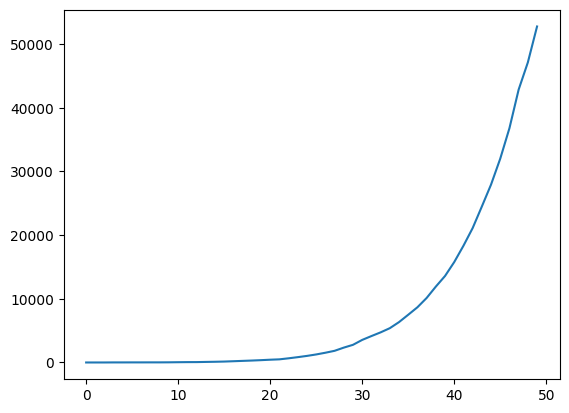

In [7]:
data['total_cases'][0:50].plot()

<Axes: >

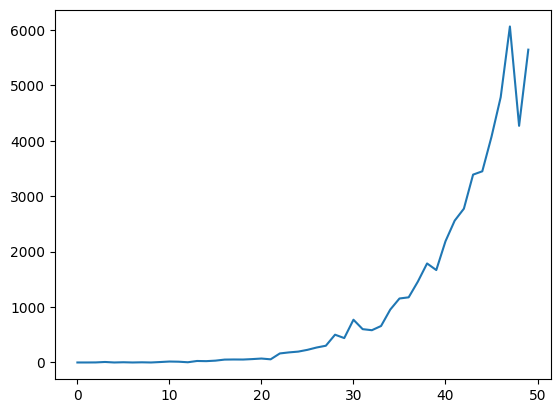

In [8]:
data['new_cases'][0:50].plot()

In [9]:
y = np.array(data['total_cases'][:50])
X = np.arange(50).reshape(-1, 1)
y_ln = np.log(y)
y_test = np.array(data['total_cases'][50 : ])
X_test = np.arange(50, len(y_test) + 50).reshape(-1, 1)
y_test_ln = np.log(y_test)
assert(len(X) + len(X_test) == len(data) and len(y) + len(y_test) == len(data))

In [10]:
model = LinearRegression().fit(X, y_ln)

In [11]:
def MSE(a, b):
    return (a - b) @ (a - b) / len(a)
print(f"MSELoss train - {MSE(model.predict(X), y_ln)}\n")
print(f"MSELoss test - {MSE(model.predict(X_test), y_test_ln)}")

MSELoss train - 0.12183046154391232

MSELoss test - 13369.47607591342


In [12]:
D_noise = np.sum((y_ln - model.predict(np.arange(50).reshape(-1, 1)))**2) / len(y_ln)
D_noise

0.12183046154391232

In [13]:
D_inv_aprior = np.eye(2,2)/1e4
D_inv_aprior

array([[0.0001, 0.    ],
       [0.    , 0.0001]])

In [14]:
x = np.concatenate((X, np.ones(len(X))[:,None]), axis = 1)
D = np.linalg.inv(D_inv_aprior + 1 / D_noise * x.T @ x)
E = D @ (1 / D_noise  * x.T @ y_ln)
print("E =", E)
print("D =", D)

E = [0.19829096 1.82073543]
D = [[ 1.17003962e-05 -2.86659638e-04]
 [-2.86659638e-04  9.45976806e-03]]


In [15]:
xs = np.arange(0, 200)
points = np.concatenate((np.arange(50)[:,None], y_ln[:,None]), axis = 1)
models = np.random.multivariate_normal(E, D, 100)

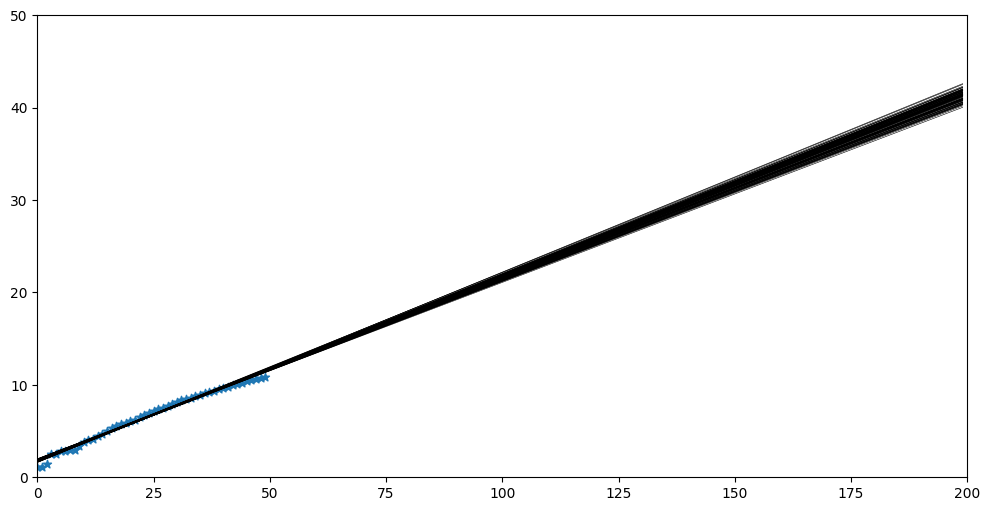

In [16]:
plt.figure(figsize=(12,6))
for w in models:
    plt.plot(xs, w[0] * xs + w[1], 'k-', lw=.4)
plt.ylim((0, 50))
plt.xlim((0, 200))
plt.scatter(points[:,0], points[:,1], marker='*')

In [17]:
data[(data['date']=='2020-05-01') | (data['date']=='2020-06-01') | (data['date']=='2020-09-01')]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
59,RUS,Europe,Russia,2020-05-01,114431.0,7933.0,6544.143,1169.0,96.0,79.143,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
90,RUS,Europe,Russia,2020-06-01,414328.0,8485.0,8700.143,4849.0,156.0,173.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
182,RUS,Europe,Russia,2020-09-01,997072.0,4670.0,4773.857,17250.0,122.0,103.714,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


In [18]:
res = []
for i in [59, 90, 182]:
    pred = np.sum(i * models[:,0] + models[:,1]) / len(models)
    pred = np.exp(pred)
    res.append((pred, data.loc[i]['total_cases'], abs(data.loc[i]['total_cases'] - pred)))    

In [19]:
for i, j in enumerate(["May 1", "June 1", "September 1"]):
    print(f"{res[i][0]} cases of coronavirus infection expected by {j}. True value - {res[i][1]}. Difference - {res[i][2]}\n")

746138.953825934 cases of coronavirus infection expected by May 1. True value - 114431.0. Difference - 631707.953825934

350360970.54869753 cases of coronavirus infection expected by June 1. True value - 414328.0. Difference - 349946642.54869753

2.9745412715993956e+16 cases of coronavirus infection expected by September 1. True value - 997072.0. Difference - 2.9745412714996884e+16



# 3 Пункт

In [20]:
const_norm = 1e9
data['total_cases'] = data['total_cases'] / const_norm

In [21]:
y_train = data['total_cases'][:50]
y_test = data['total_cases'][50:]

In [22]:
y_train = erfinv(2 * y_train - 1)
y_test = erfinv(2 * y_test - 1)

In [23]:
model = LinearRegression().fit(X, y_train)
preds = model.predict(X_test)
print(f"MSE test= {MSE(preds, y_test)}\nr2_score test= {r2_score(preds, y_test)}")

MSE test= 256.25272795558243
r2_score test= -2.5732031568030975


In [24]:
D_noise = np.sum((y_train - model.predict(X))**2) / len(y_train)
D_noise

0.0009595053157236208

In [25]:
x = np.concatenate((X, np.ones(len(X))[:,None]), axis = 1)
D = np.linalg.inv(D_inv_aprior + 1 / D_noise * x.T @ x)
E = D @ (1 / D_noise  * x.T @ y_train)
print("E =", E)
print("D =", D)

E = [ 0.02807242 -4.05889009]
D = [[ 9.21493695e-08 -2.25765955e-06]
 [-2.25765955e-06  7.45027651e-05]]


In [26]:
xs = np.arange(0, 5000)
points = np.concatenate((X, y_train[:,None]), axis = 1)

/tmp/ipykernel_22647/272825506.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  points = np.concatenate((X, y_train[:,None]), axis = 1)


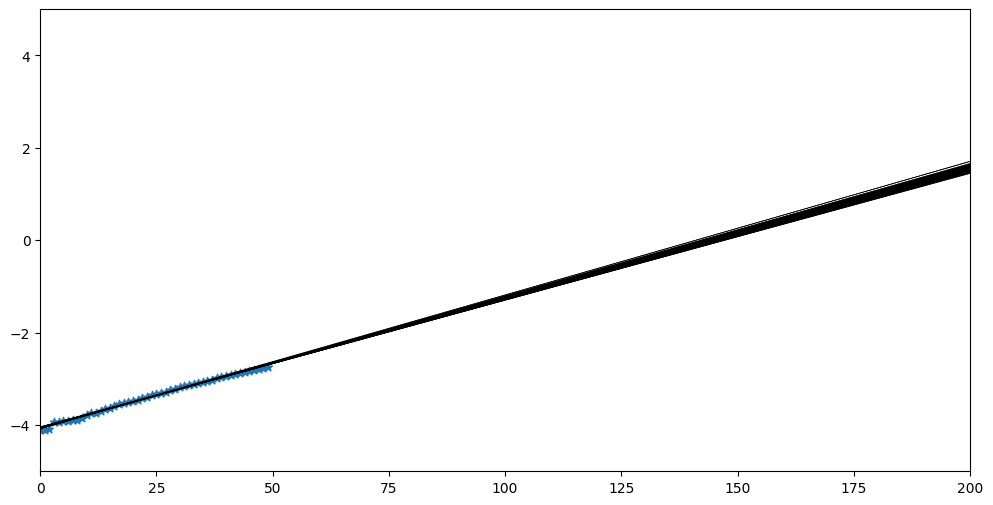

In [27]:
models = np.random.multivariate_normal(E, D, 100)
plt.figure(figsize=(12, 6))
for w in models:
    plt.plot(xs, w[0] * xs + w[1], 'k-', lw=.4)
plt.ylim((-5, 5))
plt.xlim((0, 200))
plt.scatter(points[:, 0], points[:, 1], marker='*')

In [28]:
x = np.arange(0, 200).reshape(-1, 1)
x = np.concatenate((x, np.ones(len(x))[:,None]), axis = 1)

In [29]:
preds = np.sum((x @ models.T), axis = 1) / len(x)
preds = (erf(preds) + 1) / 2
preds = preds * const_norm
new_caces = np.array(sorted([preds[i + 1] - preds[i] for i in range(len(preds) - 1)]))

In [30]:
print(f"AVG params = {np.sum(models, axis = 0) / len(models)}")

AVG params = [ 0.02810077 -4.05948226]


In [31]:
print(f"Total coronavirus cases: {preds[-1]}")
print(f"Pessimistic scenario: {new_caces[int(len(new_caces) * 0.9)]}")
print(f"Optimistic scenario: {new_caces[int(len(new_caces) * 0.1)]}")

Total coronavirus cases: 860749219.7119664
Pessimistic scenario: 7773178.363393784
Optimistic scenario: 363375.5603869576


# 4 Пункт

In [33]:
def get_models(data):
    global const_norm
    
    y_train = np.array(data['total_cases'][:50]) / const_norm
    X_train = np.arange(50).reshape(-1, 1) 
    y_test = np.array(data['total_cases'][50 : ]) / const_norm
    X_test = np.arange(50, len(y_test) + 50).reshape(-1, 1)
    assert(len(X) + len(X_test) == len(data) and len(y) + len(y_test) == len(data))

    y_train = erfinv(2 * y_train - 1)
    y_test = erfinv(2 * y_test - 1)
    model = LinearRegression().fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"MSE test= {MSE(preds, y_test)}\nr2_score test= {r2_score(preds, y_test)}")
    D_noise = np.sum((y_train - model.predict(X_train))**2) / len(y_train)
    D_inv_aprior = np.eye(2,2)/1e4
    x = np.concatenate((X_train, np.ones(len(X_train))[:,None]), axis = 1)
    D = np.linalg.inv(D_inv_aprior + 1 / D_noise * x.T @ x)
    E = D @ (1 / D_noise  * x.T @ y_train)
    print("E =", E)
    print("D =", D)
    points = np.concatenate((X_train, y_train[:,None]), axis = 1)
    models = np.random.multivariate_normal(E, D, 100)
    return models, points

In [34]:
def print_result(models, points):
    global const_norm
    xs = np.arange(0, 5000)
    plt.figure(figsize=(12, 6))
    for w in models:
        plt.plot(xs, w[0] * xs + w[1], 'k-', lw=.4)
    plt.ylim((-5, 5))
    plt.xlim((0, 200))
    plt.scatter(points[:, 0], points[:, 1], marker='*')
    x = np.arange(0, 200).reshape(-1, 1)
    x = np.concatenate((x, np.ones(len(x))[:, None]), axis=1)
    preds = np.sum((x @ models.T), axis=1) / len(x)
    preds = (erf(preds) + 1) / 2
    preds = preds * const_norm
    new_caces = np.array(sorted([preds[i + 1] - preds[i]
                            for i in range(len(preds) - 1)]))
    
    print(f"Total coronavirus cases: {preds[-1]}")
    print(f"Pessimistic scenario: {new_caces[int(len(new_caces) * 0.9)]}")
    print(f"Optimistic scenario: {new_caces[int(len(new_caces) * 0.1)]}")

In [38]:
data = pd.read_csv('/home/owid-covid-data.csv')

In [39]:
models_USA, points_USA = get_models(data[(data['location'] == 'United States') & (data['date'] >= "2020-02-28")])

MSE test= 427.3877776295493
r2_score test= -2.7099673051886217
E = [ 0.03544388 -3.75366687]
D = [[ 1.04158065e-06 -2.55187255e-05]
 [-2.55187255e-05  8.42117941e-04]]


Total coronavirus cases: 989746871.3476175
Pessimistic scenario: 9671500.533141732
Optimistic scenario: 813087.5124783274


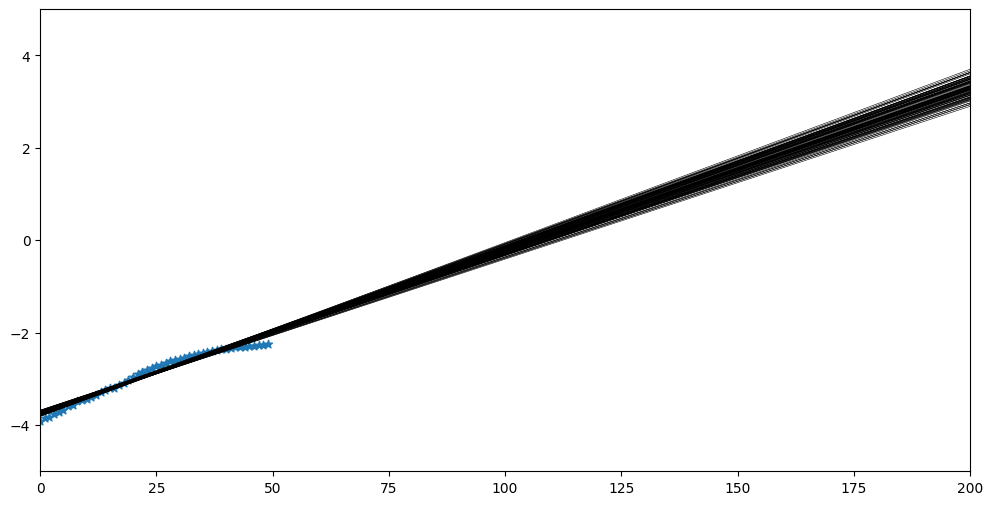

In [40]:
print_result(models_USA, points_USA)

In [41]:
models_CAN, points_CAN = get_models(data[(data['location'] == 'Canada') & (data['date'] >= "2020-02-19")])

MSE test= 208.2750283048133
r2_score test= -2.6277222259854534
E = [ 0.02480885 -4.04784053]
D = [[ 1.29618154e-07 -3.17564476e-06]
 [-3.17564476e-06  1.04796277e-04]]


Total coronavirus cases: 733254001.8219221
Pessimistic scenario: 6880951.942139685
Optimistic scenario: 291466.8738996377


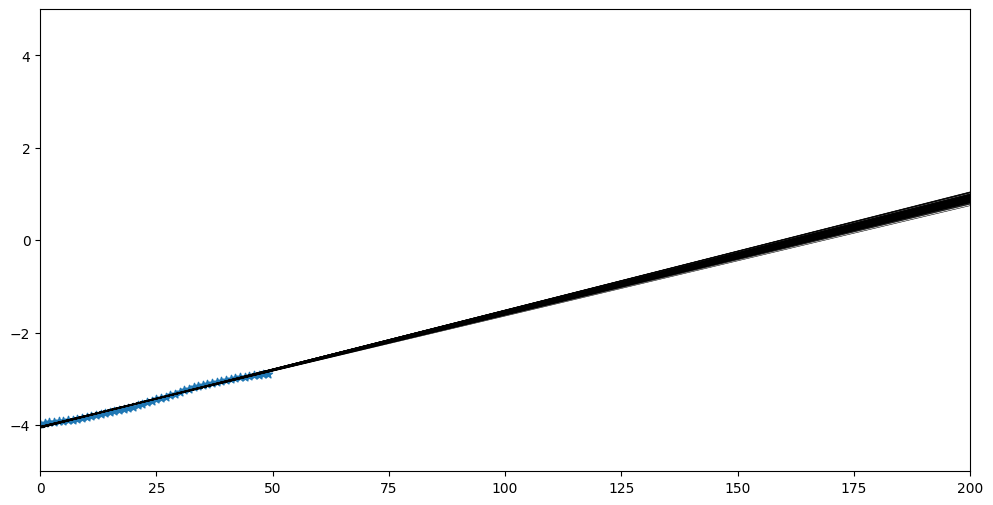

In [42]:
print_result(models_CAN, points_CAN)

In [43]:
models_CH, points_CH= get_models(data[data['location'] == 'China'])

MSE test= 66.95826125339501
r2_score test= -2.900576828762613
E = [ 0.01321595 -3.15145306]
D = [[ 1.36677488e-06 -3.34859836e-05]
 [-3.34859836e-05  1.10503746e-03]]


Total coronavirus cases: 356210834.98703253
Pessimistic scenario: 3202835.4589213133
Optimistic scenario: 459879.09401257336


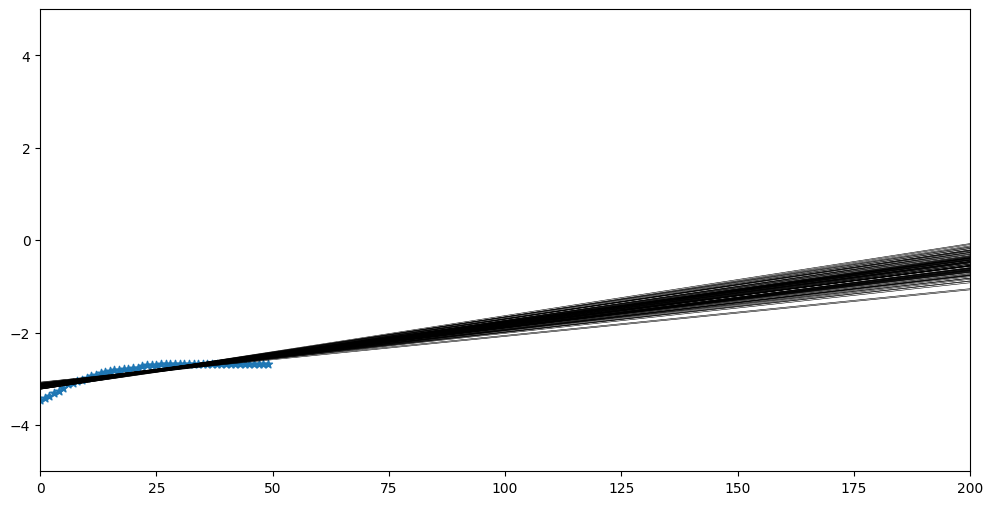

In [44]:
print_result(models_CH, points_CH)

In [45]:
models_DEU, points_DEU = get_models(data[(data['location'] == 'Germany') & (data['date'] >= "2020-02-25")])

MSE test= 254.52471019174425
r2_score test= -2.673133088485326
E = [ 0.02741079 -3.72924148]
D = [[ 8.56121731e-07 -2.09749820e-05]
 [-2.09749820e-05  6.92174407e-04]]


Total coronavirus cases: 892542630.8657057
Pessimistic scenario: 7631998.502731085
Optimistic scenario: 607761.3663173504


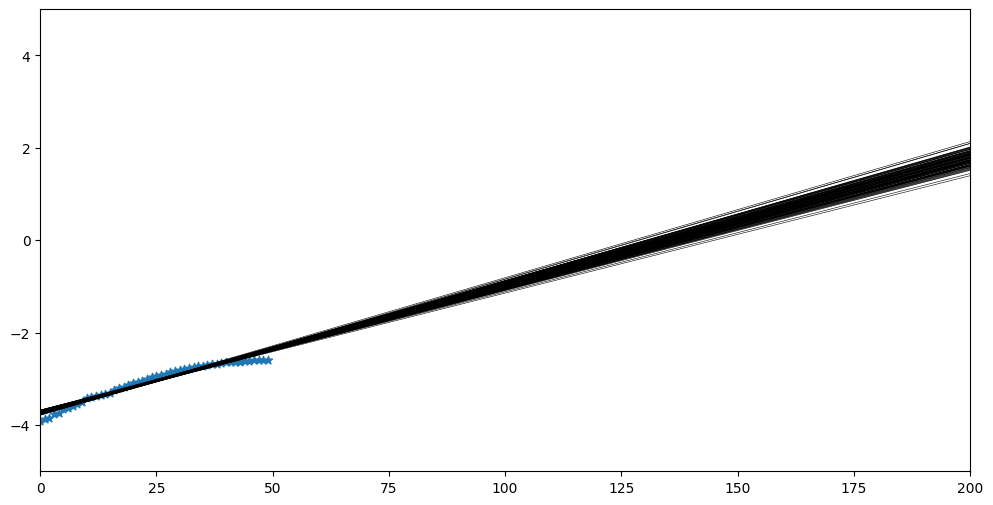

In [46]:
print_result(models_DEU, points_DEU)

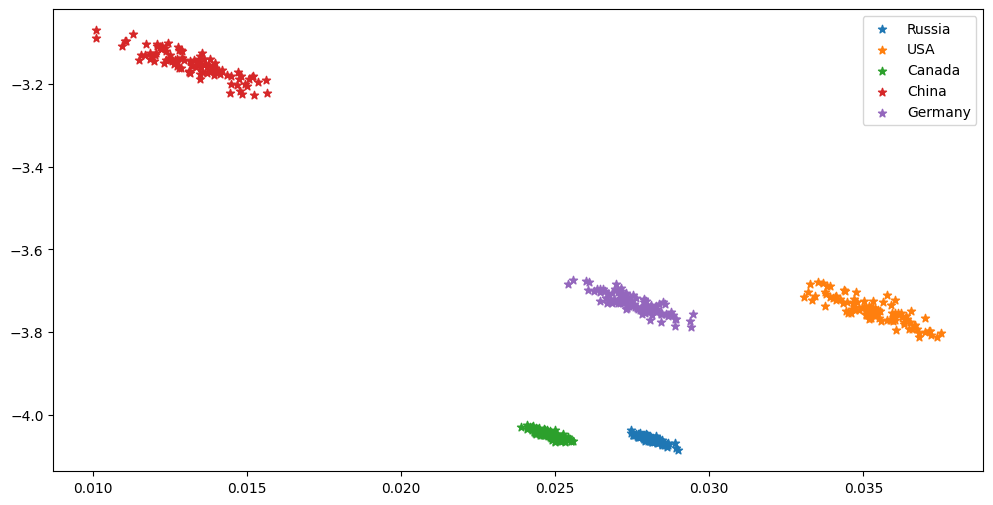

In [47]:
num = 100
plt.figure(figsize=(12, 6))
plt.scatter(models[:num, 0], models[:num, 1], marker='*', label="Russia")
plt.scatter(models_USA[:num, 0], models_USA[:num, 1], marker='*', label="USA")
plt.scatter(models_CAN[:num, 0], models_CAN[:num, 1], marker='*', label="Canada")
plt.scatter(models_CH[:num, 0], models_CH[:num, 1], marker='*', label="China")
plt.scatter(models_DEU[:num, 0], models_DEU[:num, 1], marker='*', label="Germany")
plt.legend()

Как можно заметить, страны явно имеют различные параметры и в следствии этого разделимы на кластеры.

# 5 Пункт

Главное, что я понял - с помощью линейной регрессии можно приближать даже интегральную зависимость при правильном преобразовании. Но предсказания получились слишком пессимистичными. Кривая слишком быстро выходит на насыщение. Сперва я сделал задание неправильно - обучал почти на всем датасете, а не на первых 50. И модели получались очень хорошие. Так что слишком быстрый рост можно обьяснить недостаточностью данных и что данные используются только за начальный период развития болезни.

Итого можно сказать, что коронавирус развивается достаточно быстро.

Я бы провел аналогию с другими болезнями на основании общих случаев и числа появления новых случаев. К чему это привело в прошлом. И на основании этого принял бы решение.